Submission 2 Membuat Model Machine Learning dengan Data Time Series

Bike Sharing Time Series

Read Data

In [ ]:
import pandas as pd

In [ ]:
!wget --no-check-certificate \
  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip \
  -O /tmp/Bike-Sharing-Dataset.zip

--2021-07-11 05:01:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘/tmp/Bike-Sharing-Dataset.zip’

/tmp/Bike-Sharing-D 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2021-07-11 05:01:32 (2.44 MB/s) - ‘/tmp/Bike-Sharing-Dataset.zip’ saved [279992/279992]



In [ ]:
import zipfile,os

local_zip = '/tmp/Bike-Sharing-Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp')

['Bike-Sharing-Dataset.zip',
 '__pycache__',
 'tmpnfp8xjzh.py',
 'debugger_1h2tmixcyb',
 'tmpghw2bwjj.py',
 'initgoogle_syslog_dir.0',
 'hour.csv',
 'tmp6nb_98_n.py',
 'tmp2l7ztfe_.py',
 'day.csv',
 'Readme.txt',
 'dap_multiplexer.31bd56d6ea23.root.log.INFO.20210711-042457.52',
 'dap_multiplexer.INFO']

In [ ]:
df_hour = pd.read_csv('/tmp/hour.csv', index_col='dteday')
df_hour.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Data Preprocessing

In [ ]:
# check null values
df_hour.isnull().sum()

instant       0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
# convert type into numpy array
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
df_hour.head()

df_hour = df_hour.drop(['instant', 'atemp', 'weekday', 'casual', 'registered'], axis=1)
df_hour

train_dataset = df_hour.sample(frac=0.8,random_state=0).astype(float)
test_dataset = df_hour.astype(float)

train_labels = train_dataset.pop('cnt').astype(float).values
test_labels = test_dataset.pop('cnt').astype(float).values

train_dataset = train_dataset.values[:, np.newaxis]
train_dataset.ndim

3

In [49]:
df_hour.head()

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,0,0,1,0.24,0.81,0.0,16
2011-01-01,1,0,1,1,0,0,1,0.22,0.80,0.0,40
2011-01-01,1,0,1,2,0,0,1,0.22,0.80,0.0,32
2011-01-01,1,0,1,3,0,0,1,0.24,0.75,0.0,13
2011-01-01,1,0,1,4,0,0,1,0.24,0.75,0.0,1


Building Model

In [ ]:
from keras.layers import Dense, LSTM
import tensorflow as tf

train_set = windowed_dataset(train_labels, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [ ]:
history = model.fit(
    train_dataset,
    train_labels, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.2,
    shuffle=False,
)

Epoch 1/100
174/174 [==============================] - 5s 9ms/step - loss: 188.5125 - mae: 189.0122 - val_loss: 192.7987 - val_mae: 193.2978
Epoch 2/100
174/174 [==============================] - 1s 5ms/step - loss: 187.9543 - mae: 188.4517 - val_loss: 192.1686 - val_mae: 192.6649
Epoch 3/100
174/174 [==============================] - 1s 4ms/step - loss: 187.2162 - mae: 187.7124 - val_loss: 191.2841 - val_mae: 191.7794
Epoch 4/100
174/174 [==============================] - 1s 5ms/step - loss: 186.0794 - mae: 186.5753 - val_loss: 189.7926 - val_mae: 190.2885
Epoch 5/100
174/174 [==============================] - 1s 5ms/step - loss: 183.9352 - mae: 184.4309 - val_loss: 186.7134 - val_mae: 187.2101
Epoch 6/100
174/174 [==============================] - 1s 5ms/step - loss: 178.8428 - mae: 179.3400 - val_loss: 178.4411 - val_mae: 178.9392
Epoch 7/100
174/174 [==============================] - 1s 5ms/step - loss: 162.1860 - mae: 162.6845 - val_loss: 148.5711 - val_mae: 149.0704
Epoch 8/100
1

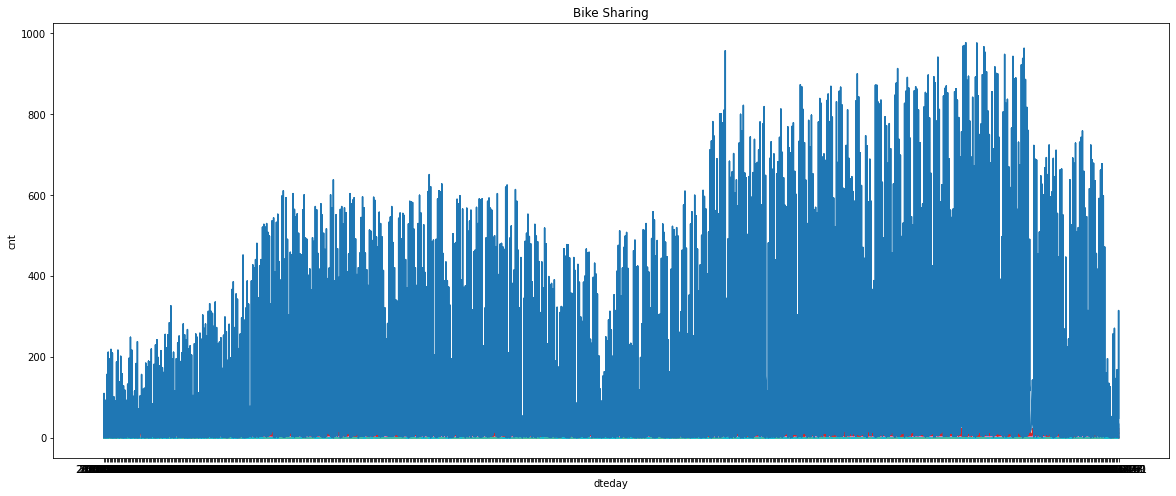

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(df_hour)
plt.title('Bike Sharing')
plt.xlabel('dteday')
plt.ylabel('cnt')
plt.show()

In [66]:
#y max
max = df_hour['cnt'].max()
print('Max value : ' )
print(max)

Max value : 
977


In [67]:
#y min
min = df_hour['cnt'].min()
print('Max value : ' )
print(min)

Max value : 
1


In [68]:
# model < 10% scaled data
x = (977 - 1) * (10 / 100)
print(x)

97.60000000000001



    Atttributes: 
    
    instant: record index
    dteday : date
    season : season (1:winter, 2:spring, 3:summer, 4:fall)
    yr : year (0: 2011, 1:2012)
    mnth : month ( 1 to 12)
    hr : hour (0 to 23)
    holiday : weather day is holiday or not (extracted from [Web Link])
    weekday : day of the week
    workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
    weathersit :
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
    atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    hum: Normalized humidity. The values are divided to 100 (max)
    windspeed: Normalized wind speed. The values are divided to 67 (max)
    casual: count of casual users
    registered: count of registered users
    cnt: count of total rental bikes including both casual and registered
